In [12]:
!pip install torch torchvision
!git clone https://github.com/ensemble-core/NdLinear.git
!cd NdLinear
!pip install .
# !pip install ndlinear

/bin/bash: line 1: git: command not found
/bin/bash: line 1: cd: NdLinear: No such file or directory
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [13]:
# !pip install ndlinear --ignore-requires-python
!pip install torch torchvision torchprofile psutil

In [14]:
!python --version

Python 3.13.2


In [15]:
!pip install matplotlib

In [16]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from ndlinear import NdLinear
from torchprofile import profile_macs
import psutil
import time
import matplotlib.pyplot as plt
import numpy as np

# Load and Prepare Dataset
- Use MNIST for simplicity (28x28 grayscale images, 10 classes).
- Code to load and preprocess:

In [23]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # CIFAR-100 mean/std
# ])
# train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
# test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
# test_loader_256 = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)  # For GFLOPs

# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
# test_loader_256 = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)  # For GFLOPs


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2860,), (0.3530,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
test_loader_256 = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)  # For GFLOPs

# Define Models

- Baseline Model: A CNN with nn.Linear layers.
- NdLinear Model: Same architecture, swapping nn.Linear with NdLinear.
- Sample CNN (2 conv layers + 2 linear layers):

# Base Model

In [24]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 2 * 2)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class NdLinearCNN(nn.Module):
    def __init__(self):
        super(NdLinearCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = NdLinear(input_dims=(128, 2, 2), hidden_size=(64, 2, 2))
        self.fc2 = NdLinear(input_dims=(64, 2, 2), hidden_size=(32, 2, 2))
        self.fc3 = NdLinear(input_dims=(32, 2, 2), hidden_size=(10, 1, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(batch_size, 128, 2, 2)
        x = self.relu(self.fc1(x))
        x = x.view(batch_size, 64, 2, 2)
        x = self.relu(self.fc2(x))
        x = x.view(batch_size, 32, 2, 2)
        x = self.fc3(x)
        x = x.view(batch_size, 10)
        return x

# Model with 1M parameters

In [25]:
class BaselineCNN_1M(nn.Module):
    def __init__(self):
        super(BaselineCNN_1M, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 2 * 2)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class NdLinearCNN_1M(nn.Module):
    def __init__(self):
        super(NdLinearCNN_1M, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = NdLinear(input_dims=(128, 2, 2), hidden_size=(64, 2, 2))
        self.fc2 = NdLinear(input_dims=(64, 2, 2), hidden_size=(32, 2, 2))
        self.fc3 = NdLinear(input_dims=(32, 2, 2), hidden_size=(10, 1, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(batch_size, 128, 2, 2)
        x = self.relu(self.fc1(x))
        x = x.view(batch_size, 64, 2, 2)
        x = self.relu(self.fc2(x))
        x = x.view(batch_size, 32, 2, 2)
        x = self.fc3(x)
        x = x.view(batch_size, 10)
        return x


# Model with 5M parameters

In [26]:
class BaselineCNN_5M(nn.Module):
    def __init__(self):
        super(BaselineCNN_5M, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(-1, 512 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class NdLinearCNN_5M(nn.Module):
    def __init__(self):
        super(NdLinearCNN_5M, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = NdLinear(input_dims=(512, 7, 7), hidden_size=(256, 2, 2))
        self.fc2 = NdLinear(input_dims=(256, 2, 2), hidden_size=(128, 1, 1))
        self.fc3 = NdLinear(input_dims=(128, 1, 1), hidden_size=(10, 1, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(batch_size, 512, 7, 7)  # Corrected to 7x7
        x = self.relu(self.fc1(x))
        x = x.view(batch_size, 256, 2, 2)
        x = self.relu(self.fc2(x))
        x = x.view(batch_size, 128, 1, 1)
        x = self.fc3(x)
        x = x.view(batch_size, 10)
        return x

# Train and Evaluate
- Train both models for a few epochs (e.g., 5) to compare performance.
- Track accuracy, parameter count, and inference time.
- Training loop:

In [27]:
# Training and evaluation functions
def train_model(model, train_loader, criterion, optimizer, num_epochs=3):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_gflops(model, test_loader):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            macs = profile_macs(model, images)
            break
    flops = macs * 2
    gflops = flops / 1e9
    return gflops

def measure_memory_usage(model, test_loader):
    model.eval()
    process = psutil.Process()
    with torch.no_grad():
        for images, _ in test_loader:
            model(images)
            memory = process.memory_info().rss / 1024 / 1024
            break
    return memory

In [30]:
# Run experiments
models = [
    (BaselineCNN, NdLinearCNN, "Base"),
    (BaselineCNN_1M, NdLinearCNN_1M, "1M"),
    (BaselineCNN_5M, NdLinearCNN_5M, "5M"),
]

baseline_accs, ndlinear_accs = [], []
baseline_params, ndlinear_params = [], []
baseline_gflops, ndlinear_gflops = [], []
baseline_memory, ndlinear_memory = [], []

for baseline_cls, ndlinear_cls, size in models:
    print(f"Training {size} models...")
    baseline_model = baseline_cls()
    ndlinear_model = ndlinear_cls()
    criterion = nn.CrossEntropyLoss()
    baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)
    ndlinear_optimizer = torch.optim.Adam(ndlinear_model.parameters(), lr=0.001)

    print("\nBaselineCNN:")
    train_model(baseline_model, train_loader, criterion, baseline_optimizer)
    print("\nNdLinearCNN:")
    train_model(ndlinear_model, train_loader, criterion, ndlinear_optimizer)

    baseline_acc = evaluate_model(baseline_model, test_loader)
    ndlinear_acc = evaluate_model(ndlinear_model, test_loader)
    baseline_param = count_parameters(baseline_model)
    ndlinear_param = count_parameters(ndlinear_model)
    baseline_gflop = measure_gflops(baseline_model, test_loader_256)
    ndlinear_gflop = measure_gflops(ndlinear_model, test_loader_256)
    baseline_mem = measure_memory_usage(baseline_model, test_loader)
    ndlinear_mem = measure_memory_usage(ndlinear_model, test_loader)

    baseline_accs.append(baseline_acc)
    ndlinear_accs.append(ndlinear_acc)
    baseline_params.append(baseline_param)
    ndlinear_params.append(ndlinear_param)
    baseline_gflops.append(baseline_gflop)
    ndlinear_gflops.append(ndlinear_gflop)
    baseline_memory.append(baseline_mem)
    ndlinear_memory.append(ndlinear_mem)

    print(f"\nBaseline {size} - Acc: {baseline_acc:.2f}%, Params: {baseline_param}, GFLOPs: {baseline_gflop:.2f}, Memory: {baseline_mem:.2f} MB")
    print(f"NdLinear {size} - Acc: {ndlinear_acc:.2f}%, Params: {ndlinear_param}, GFLOPs: {ndlinear_gflop:.2f}, Memory: {ndlinear_mem:.2f} MB\n")

Training Base models...

BaselineCNN:
Epoch [1/3], Loss: 0.3826
Epoch [2/3], Loss: 0.5813
Epoch [3/3], Loss: 0.1019

NdLinearCNN:
Epoch [1/3], Loss: 0.5418
Epoch [2/3], Loss: 0.2344
Epoch [3/3], Loss: 0.4451

Baseline Base - Acc: 90.02%, Params: 291466, GFLOPs: 6.49, Memory: 1084.39 MB
NdLinear Base - Acc: 87.64%, Params: 136648, GFLOPs: 6.43, Memory: 1084.39 MB

Training 1M models...

BaselineCNN:
Epoch [1/3], Loss: 0.6079
Epoch [2/3], Loss: 0.3018
Epoch [3/3], Loss: 0.1383

NdLinearCNN:
Epoch [1/3], Loss: 0.2747
Epoch [2/3], Loss: 0.2859
Epoch [3/3], Loss: 0.2490

Baseline 1M - Acc: 89.68%, Params: 291466, GFLOPs: 6.49, Memory: 1084.38 MB
NdLinear 1M - Acc: 88.87%, Params: 136648, GFLOPs: 6.43, Memory: 1084.38 MB

Training 5M models...

BaselineCNN:
Epoch [1/3], Loss: 0.1593
Epoch [2/3], Loss: 0.1412
Epoch [3/3], Loss: 0.0367

NdLinearCNN:
Epoch [1/3], Loss: 0.4581
Epoch [2/3], Loss: 0.2991
Epoch [3/3], Loss: 0.2383

Baseline 5M - Acc: 90.45%, Params: 7090314, GFLOPs: 35.19, Memory: 

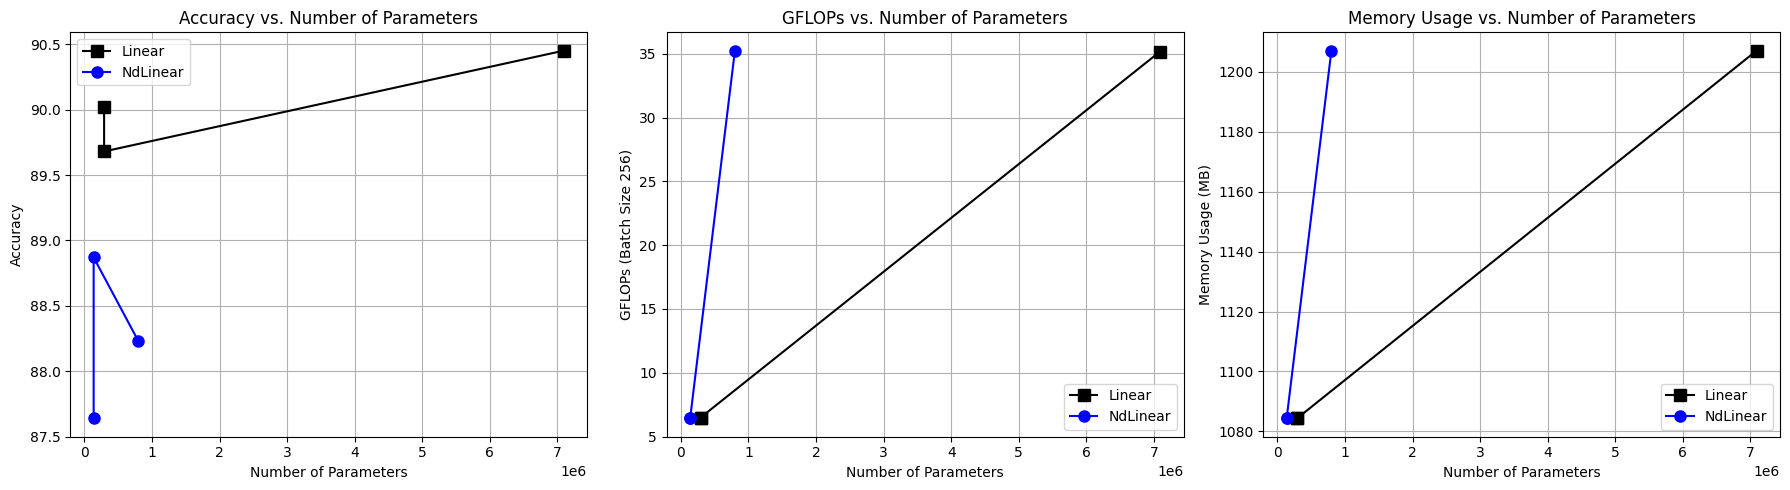

In [31]:
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy vs Parameters
axes[0].plot(baseline_params, baseline_accs, 'ks-', label='Linear', markersize=8)
axes[0].plot(ndlinear_params, ndlinear_accs, 'bo-', label='NdLinear', markersize=8)
axes[0].set_title('Accuracy vs. Number of Parameters')
axes[0].set_xlabel('Number of Parameters')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# GFLOPs vs Parameters
axes[1].plot(baseline_params, baseline_gflops, 'ks-', label='Linear', markersize=8)
axes[1].plot(ndlinear_params, ndlinear_gflops, 'bo-', label='NdLinear', markersize=8)
axes[1].set_title('GFLOPs vs. Number of Parameters')
axes[1].set_xlabel('Number of Parameters')
axes[1].set_ylabel('GFLOPs (Batch Size 256)')
axes[1].legend()
axes[1].grid(True)

# Memory Usage vs Parameters
axes[2].plot(baseline_params, baseline_memory, 'ks-', label='Linear', markersize=8)
axes[2].plot(ndlinear_params, ndlinear_memory, 'bo-', label='NdLinear', markersize=8)
axes[2].set_title('Memory Usage vs. Number of Parameters')
axes[2].set_xlabel('Number of Parameters')
axes[2].set_ylabel('Memory Usage (MB)')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Measure Metrics
- Parameter Count

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Baseline Parameters: {count_parameters(baseline_model)}')
print(f'NdLinear Parameters: {count_parameters(ndlinear_model)}')

Baseline Parameters: 7090314
NdLinear Parameters: 798900


- Inference Time:

In [33]:
import time
def measure_inference_time(model, test_loader):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for images, _ in test_loader:
            model(images)
    return time.time() - start_time

baseline_time = measure_inference_time(baseline_model, test_loader)
ndlinear_time = measure_inference_time(ndlinear_model, test_loader)
print(f'Baseline Inference Time: {baseline_time:.2f}s')
print(f'NdLinear Inference Time: {ndlinear_time:.2f}s')

Baseline Inference Time: 13.35s
NdLinear Inference Time: 14.13s


# Visualize and Document
- Plot accuracy, parameter count, and inference time (bar charts or tables).
- Sample visualization:

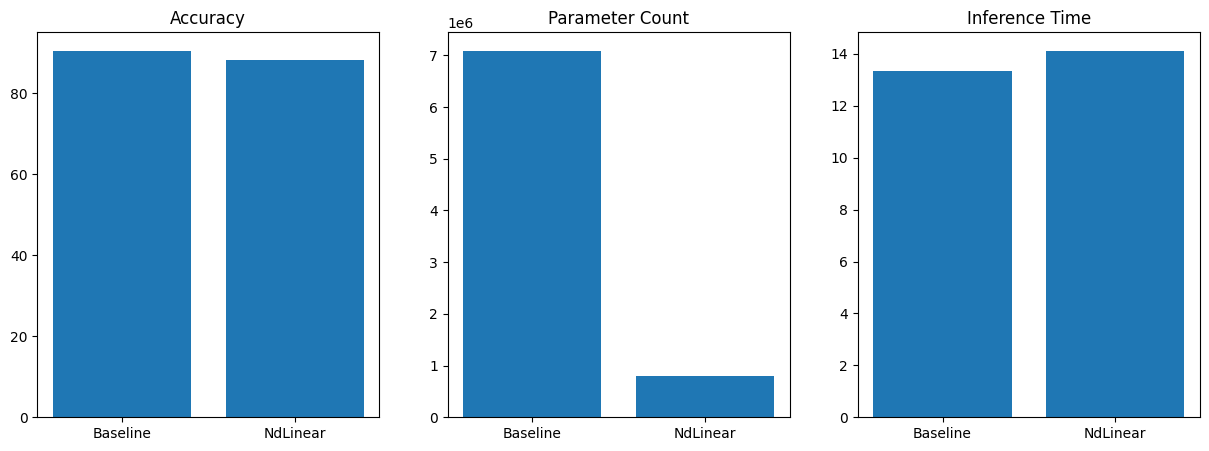

In [34]:
import matplotlib.pyplot as plt
metrics = {
    'Model': ['Baseline', 'NdLinear'],
    'Accuracy (%)': [baseline_acc, ndlinear_acc],
    'Parameters': [count_parameters(baseline_model), count_parameters(ndlinear_model)],
    'Inference Time (s)': [baseline_time, ndlinear_time]
}
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].bar(metrics['Model'], metrics['Accuracy (%)'])
ax[0].set_title('Accuracy')
ax[1].bar(metrics['Model'], metrics['Parameters'])
ax[1].set_title('Parameter Count')
ax[2].bar(metrics['Model'], metrics['Inference Time (s)'])
ax[2].set_title('Inference Time')
plt.show()